In [85]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import LocalOutlierFactor

In [83]:
X, Y = datasets.make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=0.4, random_state=0)

dist_matrix = scipy.spatial.distance_matrix(X, X)
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.466477,0.345645,0.637414,3.928070,3.531418,4.068189,3.022841,0.444883,4.005753,...,0.524355,3.319645,1.009731,0.266363,0.316039,0.138677,3.277684,2.724083,3.357217,4.069619
1,0.466477,0.000000,0.673256,0.321355,3.858008,3.333251,3.935289,2.775609,0.287633,3.784798,...,0.060243,3.142487,0.543540,0.330034,0.589983,0.455312,3.192277,2.676379,3.242699,3.874538
2,0.345645,0.673256,0.000000,0.682748,4.269712,3.874373,4.413740,3.358297,0.484570,4.346433,...,0.732386,3.664110,1.186257,0.345961,0.643333,0.483375,3.621297,3.064739,3.702428,4.413139
3,0.637414,0.321355,0.682748,0.000000,4.158128,3.591566,4.216971,3.013023,0.205708,4.030194,...,0.327521,3.410733,0.561483,0.385959,0.858156,0.688033,3.490319,2.984465,3.532502,4.131923
4,3.928070,3.858008,4.269712,4.158128,0.000000,1.145984,0.555527,1.685833,4.133640,1.327712,...,3.835521,1.074051,3.820818,4.074314,3.628768,3.789422,0.669986,1.206071,0.688912,1.102873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.138677,0.455312,0.483375,0.688033,3.789422,3.397937,3.930445,2.895348,0.516109,3.874149,...,0.506188,3.184622,0.983818,0.357349,0.190542,0.000000,3.139049,2.585536,3.219071,3.935544
196,3.277684,3.192277,3.621297,3.490319,0.669986,0.868814,0.855692,1.188355,3.469702,1.277952,...,3.168676,0.662868,3.151444,3.415256,2.983806,3.139049,0.000000,0.588176,0.218658,1.152021
197,2.724083,2.676379,3.064739,2.984465,1.206071,1.255723,1.441046,1.280449,2.945856,1.738279,...,2.658356,0.998712,2.696849,2.877594,2.423137,2.585536,0.588176,0.000000,0.741819,1.665917
198,3.357217,3.242699,3.702428,3.532502,0.688912,0.654341,0.718639,1.037276,3.524372,1.060947,...,3.215464,0.466769,3.165209,3.480626,3.071346,3.219071,0.218658,0.741819,0.000000,0.944993


In [245]:
class LOF():
    def __init__(self, k, contamination):
        self.k = k
        self.contamination = contamination


    def _kneibors(self, X, k):
        dist_matrix = scipy.spatial.distance_matrix(X, X)
        neighbors_index = np.argsort(dist_matrix, axis=1)[:, 1:k+1]
        distances = np.sort(dist_matrix, axis=1)[:, 1:k+1]
        return distances, neighbors_index


    # 到達可能距離を採用することで、自分の近傍点との距離が小さいと思っていたが、そもそもその近傍点が全体から孤立していた場合に、異常と判断ができる
    def _reachability_distance(self, distances, neighbors_index):
        most_distance_index = neighbors_index[:, -1]
        return np.maximum(distances, distances[most_distance_index])


    # 到達可能距離の平均の逆数 -> 周囲の点への到達可能距離が大きいほど、密度が低いことになる
    def _local_reachability_density(self, reachability_dist):
        return (1. / np.mean(reachability_dist, axis=1))


    # 近傍の点における局所密度と比べて、自身の局所密度がどうかを表す -> 1より大きい場合は密度が低い
    def _local_outlier_factor(self, X):
        distances, neighbors_index = self._kneibors(X, self.k)
        reachability_dist = self._reachability_distance(distances, neighbors_index)
        lrd = self._local_reachability_density(reachability_dist)

        return lrd[neighbors_index].sum(axis=1) / lrd / self.k
    
    def fit_predict(self, X):
        lof = self._local_outlier_factor(X)
        offset = np.percentile(lof, 100.0 * (1 - self.contamination))
        return np.where(lof > offset, -1, 1)

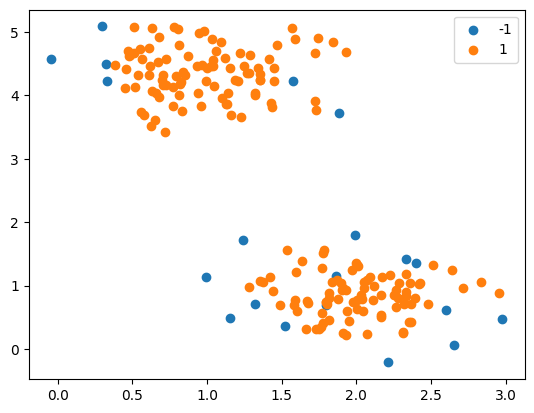

In [262]:
labels = LOF(k=5, contamination=0.1).fit_predict(X)
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(X[labels == label, 0], X[labels == label, 1], label=label)
plt.legend()

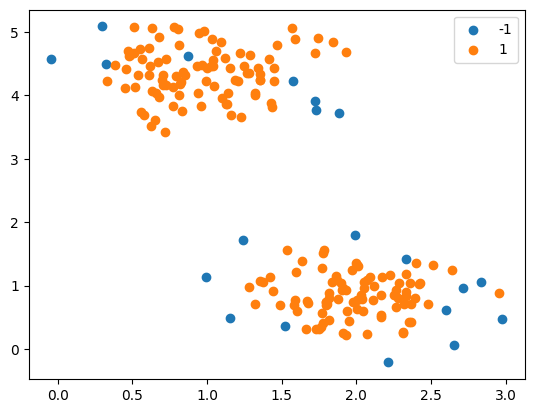

In [260]:
labels = LocalOutlierFactor(n_neighbors=5, contamination=0.1).fit_predict(X)
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(X[labels == label, 0], X[labels == label, 1], label=label)
plt.legend()